# BSc Thesis: Evaluation of Decision Tree and Random Forest Classifiers in the Finance Domain

## Table of Contents
0. Preparation
1. Data Preparation Stage
2. Feature Extraction
3. Classification
4. Evaluation of Models
5. Visualisations

# 0 | Preparation

### Imports

In [83]:
# Data manipulation and arrays
import pandas as pd
import numpy as np

# Machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn import metrics

# Plottig
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

### Constant variables

In [103]:
# Define filenames for technology stock .CSV datasets
MSFT_DATA = "Datasets/Kaggle_SnP500_MSFT_2013-2018.csv"
AAPL_DATA = "Datasets/Kaggle_SnP500_AAPL_2013-2018.csv"
GOOGL_DATA = "Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv"
HP_DATA = "Datasets/Kaggle_SnP500_HP_2013-2018.csv"
IBM_DATA = "Datasets/Kaggle_SnP500_IBM_2013-2018.csv"
WU_DATA = "Datasets/Kaggle_SnP500_WU_2013-2018.csv"
XRX_DATA = "Datasets/Kaggle_SnP500_XRX_2013-2018.csv"
TECH_GROUP = [] # this list will be filled with DataFrames of the above .CSVs

# Define time horizons to compare classification results for 1-day to 1-year predictions
TIME_HORIZONS = [1, 5, 10, 30, 100, 365]

# Define verbosity
VERBOSE = False

# Centrally define if figures should be saved to ./plots/
SAVE_FIG = False

<class 'list'>


# 1 | Data Preparation Stage
- Load data and adjust columns as needed
- Extract features for technical analysis
- Define class for later classification
- Detect anomalies in the datasets
- No feature selection needed as embedded in Decision Trees (DT) and Random Forests (RF)

## 1.1. | Load Datasets
- For an apples-to-apples comparison, technology companies are analyzed (idea: companies/stocks within an industry have similar drivers)
- Selected stocks differ in price trends (upward- vs constant- vs downward trend)

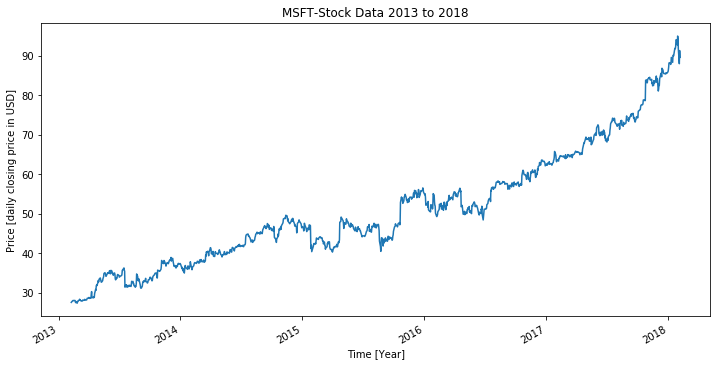

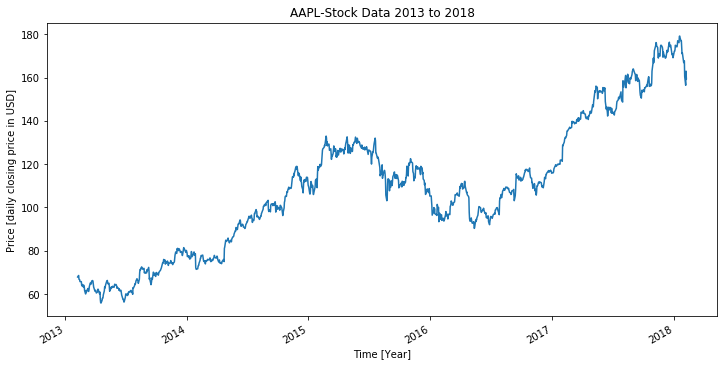

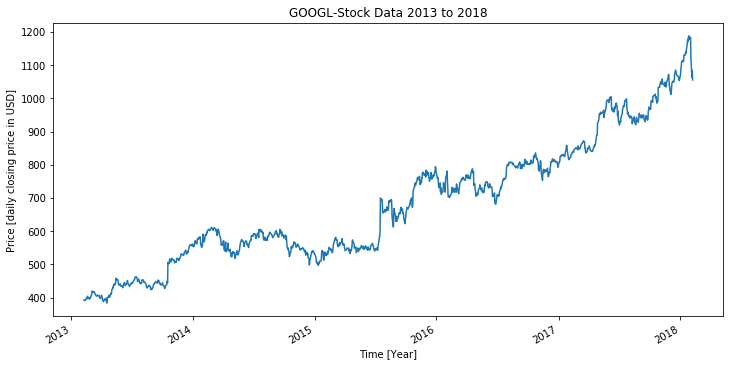

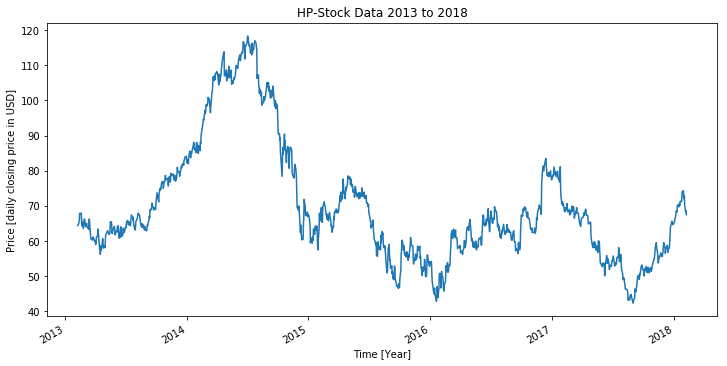

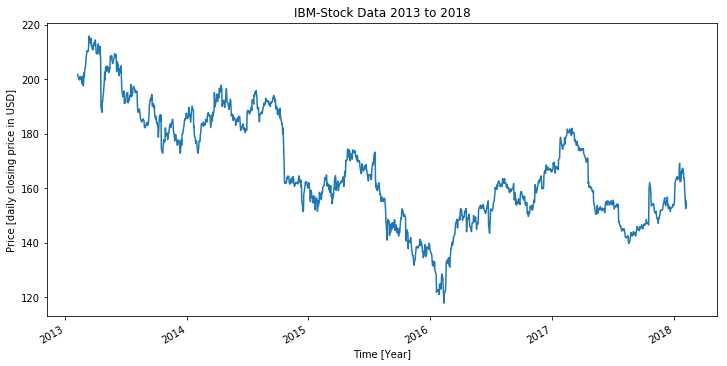

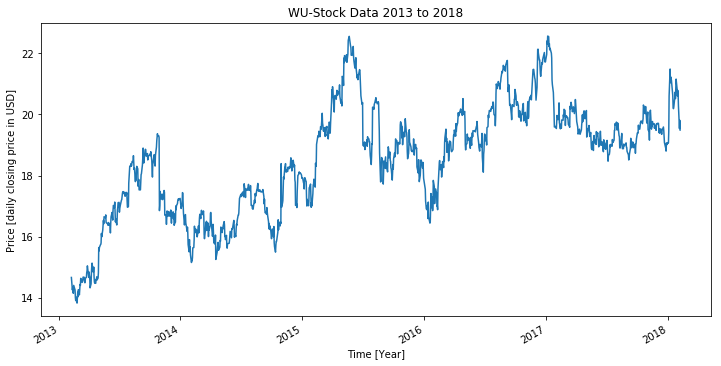

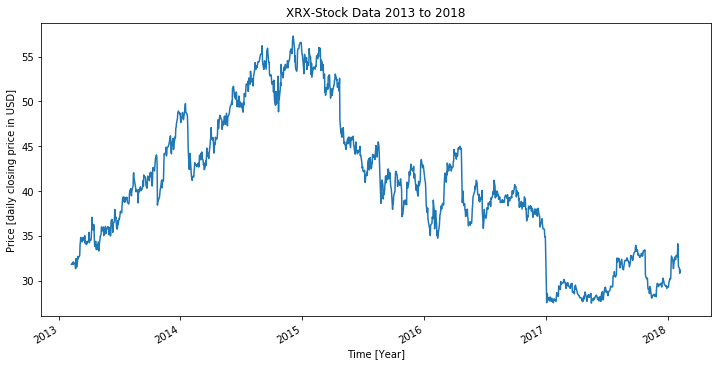

In [104]:
def load_OHLC_data(filename=MSFT_DATA, verbose=VERBOSE, save_fig=SAVE_FIG):
    """
    Loads basic stock data (date, name, open, high, low, close) from a given .CSV file and returns a corresponding DataFrame.
    Unnecessary categorical columns are dropped, and necessary columns (e.g. month as number) are added.
    """
    try:
        df = pd.read_csv(filename)
        
        # Visualize loaded time series data
        df["date"] = pd.to_datetime(df["date"])
        df.plot(x="date", y="close", figsize=(12,6), legend=None)
        plt.xlabel("Time [Year]")
        plt.ylabel("Price [daily closing price in USD]")
        plt.title(df["Name"][0] + "-Stock Data 2013 to 2018");
        if save_fig is True:
            plt.savefig("./Plots/" + df["Name"][0] + "-Stock-Price-Plot.jpeg")
        
        # Drop not needed categorical columns
        # df = df.drop(columns=["Name"])
        
        # Convert date to numerical month to possibly detect cyclicality (e.g. christmas effect) in time series
        df["month"] = df["date"].astype("datetime64[ns]").dt.month
        
        if verbose is True:
            print("Loaded DataFrame has the following columns:")
            for col in df:
                print("Column \'" + col + "\' with type", type(df[col][0]), ", e.g.", df[col][0])
            print("df.head():")
            print(df.head())
        
        return df
    except:
        print("Error, failed to find or load OHLC data from file with name \'"
              + filename + "\'. Please provide well-formed CSV file with OHLC stock data")


df_MSFT = load_OHLC_data(MSFT_DATA)
df_AAPL = load_OHLC_data(AAPL_DATA)
df_GOOGL = load_OHLC_data(GOOGL_DATA)
df_HP = load_OHLC_data(HP_DATA)
df_IBM = load_OHLC_data(IBM_DATA)
df_WU = load_OHLC_data(WU_DATA)
df_XRX = load_OHLC_data(XRX_DATA)
TECH_GROUP = [df_MSFT, df_AAPL, df_GOOGL, df_HP, df_IBM, df_WU, df_XRX]

## 1.2 | Extract Features
- Common metrics for technical analysis are calculated to be later used as features
- Source for technical indicators: TA-lib, https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code

In [123]:
def extract_OHLC_features(df, time_horizons=TIME_HORIZONS):
    """
    Extract common technical stock analysis features from given OHLC stock data for distinct time horizons
    """
    # Calculate technical features for each time horizon
    for horizon in time_horizons:
        # Future return of stock over given time horizon (e.g. this week's Monday to next week's Monday)
        df["return_future_" + str(horizon) + "d"] = (df["close"].shift(-1*horizon)/df["close"])-1
        
        # Past return of stock over given time horizon (e.g. last week's Monday to this week's Monday)
        df["return_past_" + str(horizon) + "d"] = (df["close"].shift(horizon)/df["close"])-1
        
        # Implied volatility measured by standard deviation
        df["volatility_" + str(horizon) + "d"] = df["close"].rolling(horizon).std()
        
        # Moving averages (ma)
        df["ma_" + str(horizon) + "d"] = df["close"].rolling(horizon).mean()
        
#         Exponentially-weighted moving average (ewma)
#         df["ewma_" + str(horizon) + "d"] = pd.ewma(df["close"], span=horizon, min_periods=horizon-1)
#         df["ewma_" + str(horizon) + "d"] = df["close"].ewm(span=horizon, min_periods=horizon-1)
        
        # Momentum (absolute change in price over past horizon)
        df["momentum_" + str(horizon) + "d"] = df["close"].diff(horizon)
        
        # Rate of change during horizon period
        df["rateofchange_" + str(horizon) + "d"] = (df["close"].diff(horizon-1)) / (df["close"].shift(horizon-1))
        
#         Bollinger Bands
#         df["bollingerbands1_" + str(horizon) + "d"] = 4*df["volatility_" + str(horizon) + "d"] / df["ma_" + str(horizon) + "d"]
#         df["bollingerbands2_" + str(horizon) + "d"] = (df["close"] - df["ma_" + str(horizon) + "d"] + 2*df["volatility_" + str(horizon) + "d"]) / 4*df["volatility_" + str(horizon) + "d"]
        
        # TBD add other talib indicators from #Pivot Points, Supports and Resistances
    
    # OHLC average is used for stock price average of a given day
    df["ohlc_avg"] = df[["open", "high", "low", "close"]].mean(axis=1)
    
    # Replace NaNs with zeroes
    df = df.fillna(value=0)
    return df


print("#Features before extraction:", len(df_MSFT.columns))
df_MSFT = extract_OHLC_features(df_MSFT, TIME_HORIZONS)
print("#Features after extraction:", len(df_MSFT.columns))
df_AAPL = extract_OHLC_features(df_AAPL, TIME_HORIZONS)
df_GOOGL = extract_OHLC_features(df_GOOGL, TIME_HORIZONS)
df_HP = extract_OHLC_features(df_HP, TIME_HORIZONS)
df_IBM = extract_OHLC_features(df_IBM, TIME_HORIZONS)
df_WU = extract_OHLC_features(df_WU, TIME_HORIZONS)
df_XRX = extract_OHLC_features(df_XRX, TIME_HORIZONS)

if VERBOSE is True:
    print("With extracted features, dfMSFT.head() now yields following format:")
    print(df_MSFT.head())

#Features before extraction: 45
#Features after extraction: 51


## 1.3 | Anomaly Detection
- Anomaly defined as: abs(return_past_1d) > threshold=5% (default)
- Such anomalies (5% threshold) occur in about 1.4% of instances for seven tech stock datasets

In [114]:
def detect_anomalies(df, verbose=VERBOSE, threshold=0.05):
    """
    Iterates through the DataFrame and prints out all dates where 1-day-return is greater than threshold=5% (default)
    """
    if verbose is True:
        print("Detecting anomalies where abs(1-day-return)>" + str(threshold*100) + " % for " + df["Name"][0])
    for i in range(len(df)):
        x = df["return_past_1d"][i]
        d = df["date"][i]
        if (abs(x) > threshold):
            global anomaly_counter
            anomaly_counter = anomaly_counter + 1
            if verbose is True:
                print("Anomaly: 1-day-return of " + str(round(x * 100, 2)) + "% on " + d.strftime("%A, %d.%m.%Y"))


anomaly_counter = 0
detect_anomalies(df_MSFT)
detect_anomalies(df_AAPL)
detect_anomalies(df_GOOGL)
detect_anomalies(df_HP)
detect_anomalies(df_IBM)
detect_anomalies(df_WU)
detect_anomalies(df_XRX)

print("anomaly_counter=" + str(counter) + ", or " + str(round(counter*100/(7*len(df_MSFT)), 2)) + "% of instances")

anomaly_counter=124, or 1.41% of instances


## 1.4 | Define classes
- This notebook evaluates DT and RF for stock recommendation (application no. 2 in thesis)
- Classes are defined for each time horizon to enable for later comparisons
- Base columns, on which classes are built, are removed to prevent illegal future-peeking features

In [128]:
def define_classes(df, time_horizons=TIME_HORIZONS):
    """
    Create target column in df: 1 means 'Yes, investor should buy stock', 0 means 'No, investor should not buy stock'.
    The assumed trading strategy here is, that the investor buy the stock on a given date and sells it after the horizon period.
    Also removes illegal (future-peeking) columns
    """
    for horizon in time_horizons:
        base_column_name = "return_future_" + str(horizon) + "d"
        class_name = "class_" + str(horizon) + "d"
        
        if class_name not in df.columns:
            df[class_name] = np.where(df[base_column_name] > 0, 1, 0)
            # Remove base column as it would be an illegal (future-peeking) feature
        if base_column_name in df.columns:
            df = df.drop(columns=[base_column_name])
    return df


df_MSFT = define_classes(df_MSFT)
df_AAPL = define_classes(df_AAPL)
df_GOOGL = define_classes(df_GOOGL)
df_HP = define_classes(df_HP)
df_IBM = define_classes(df_IBM)
df_WU = define_classes(df_WU)
df_XRX = define_classes(df_XRX)

print("classes (class_<horizon>d) created, base columns (return_future_<horizon>d) removed")

classes (class_<horizon>d) created, base columns (return_future_<horizon>d) removed


## 1.5 | Check class balance
- The two classes Yes (1) and No (0) should be balanced, else the evaluation technique must be adapted

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


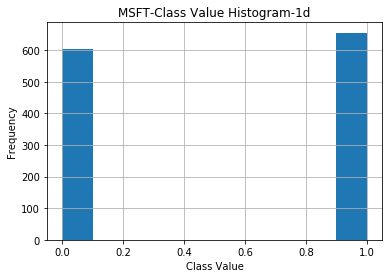

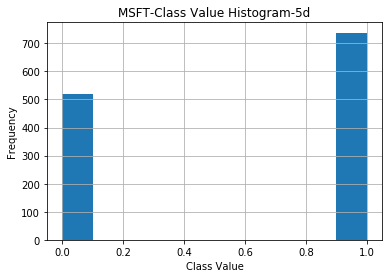

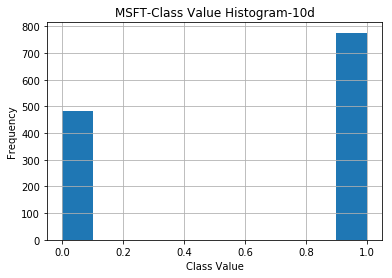

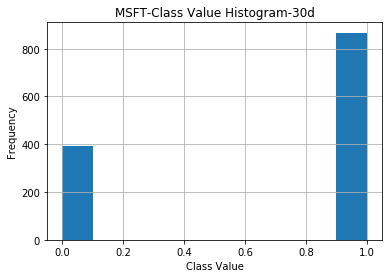

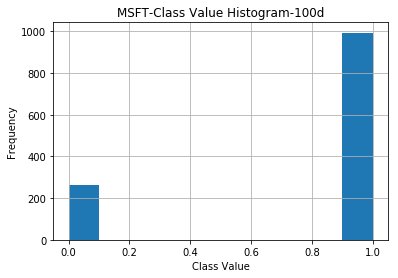

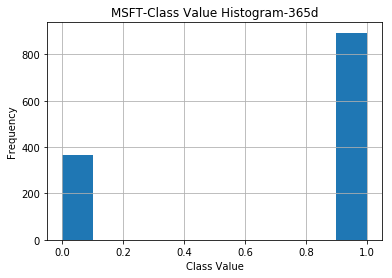

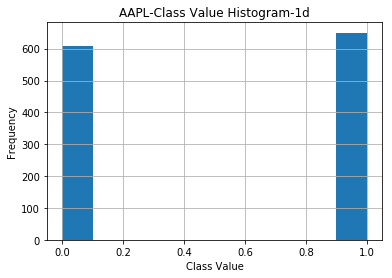

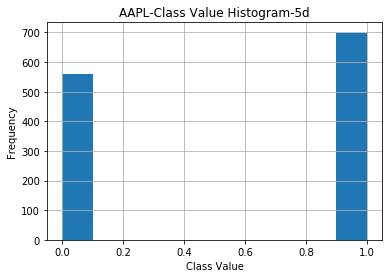

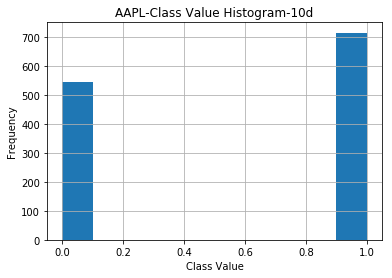

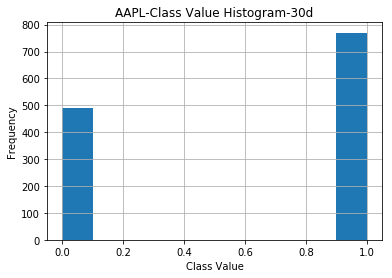

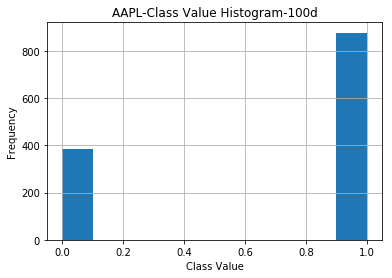

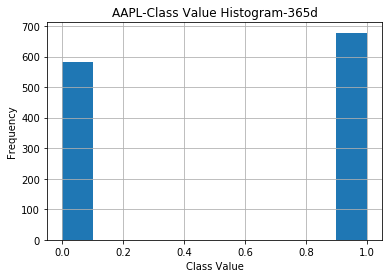

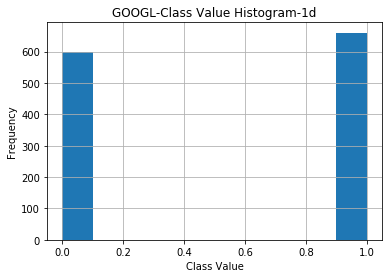

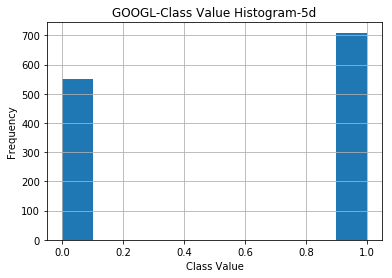

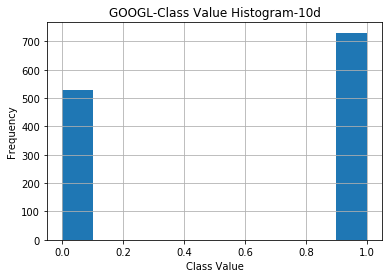

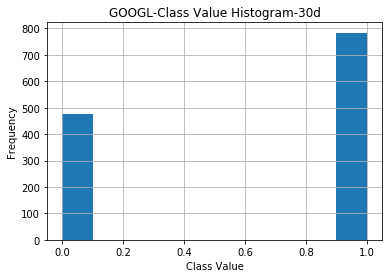

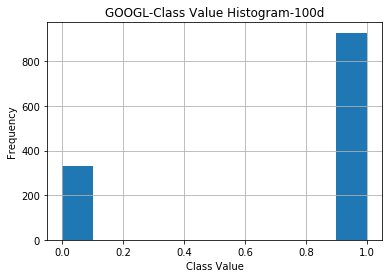

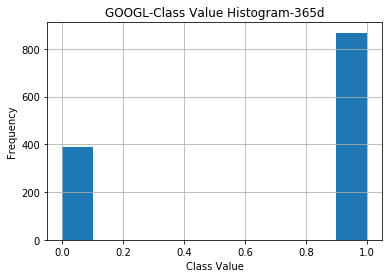

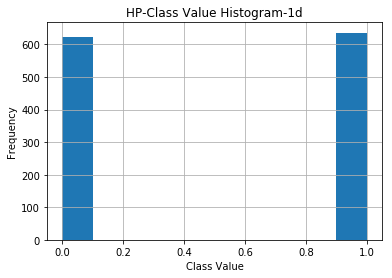

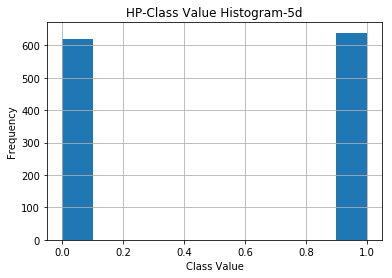

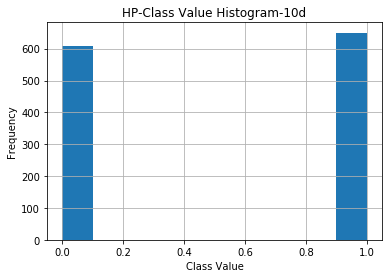

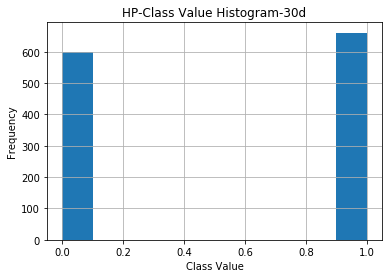

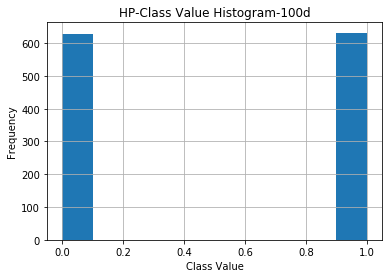

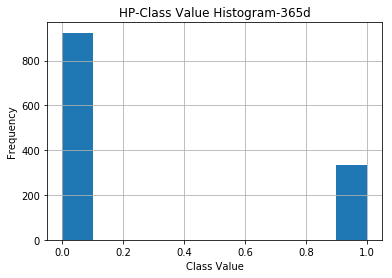

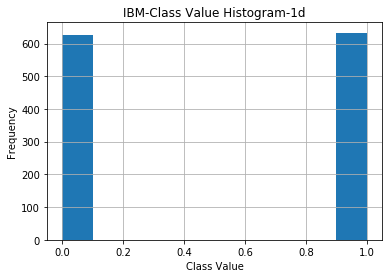

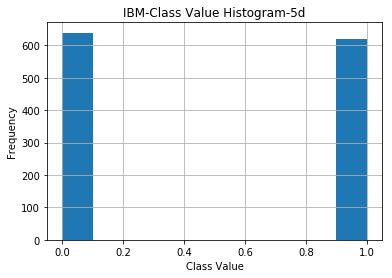

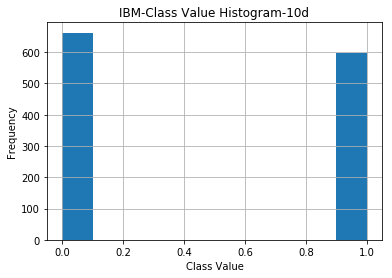

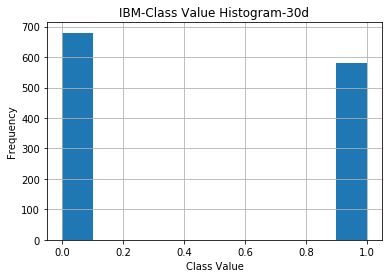

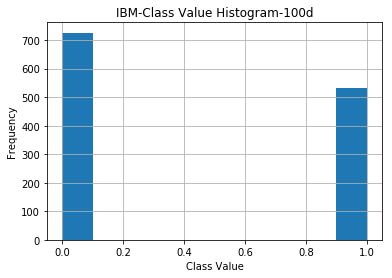

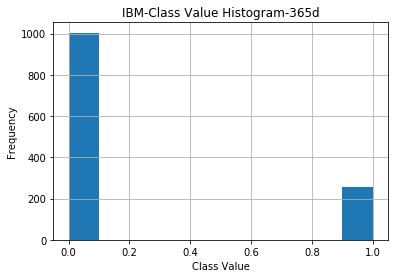

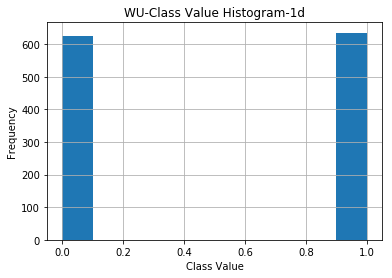

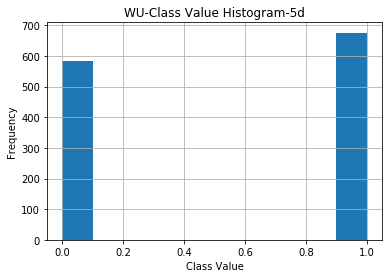

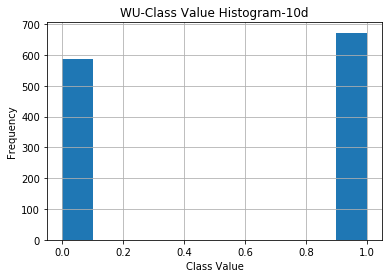

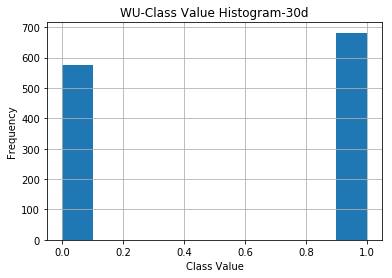

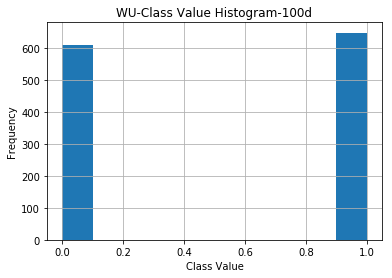

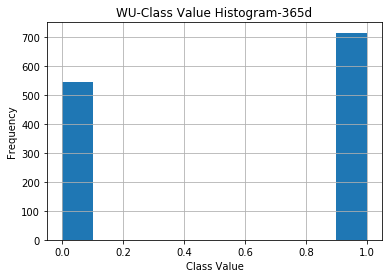

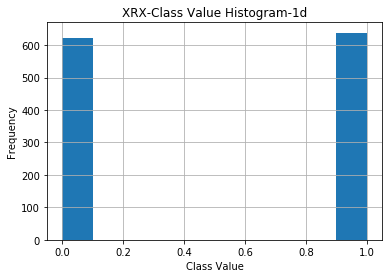

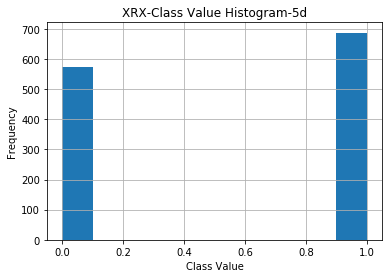

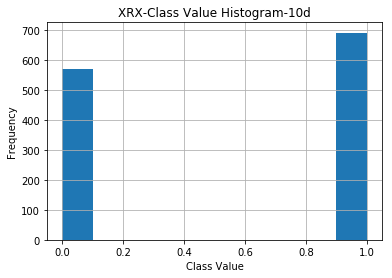

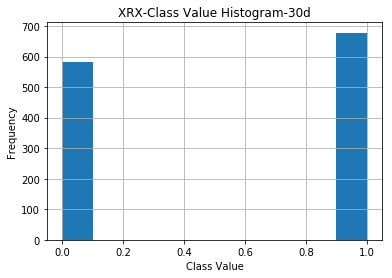

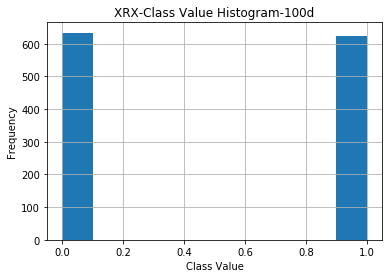

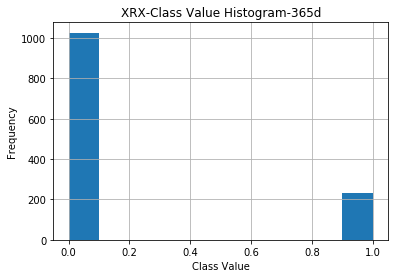

In [153]:
def check_class_balance(df=df_MSFT, time_horizons=TIME_HORIZONS, verbose=VERBOSE, save_fig=SAVE_FIG):
    for horizon in time_horizons:
        class_name = "class_" + str(horizon) + "d"
        if verbose is True:
            print(df[class_name].value_counts())

        plt.figure()
        df[class_name].hist()
        plt.xlabel("Class Value")
        plt.ylabel("Frequency")
        plt.title(df["Name"][0] + "-Class Value Histogram-" + str(horizon) + "d")
        if save_fig is True:
            plt.savefig("./Plots/Class-Balance-Check/" + df["Name"][0] + "-Class-Balance-Histogram-" + str(horizon) + "d.jpeg")


check_class_balance(df_MSFT)
check_class_balance(df_AAPL)
check_class_balance(df_GOOGL)
check_class_balance(df_HP)
check_class_balance(df_IBM)
check_class_balance(df_WU)
check_class_balance(df_XRX)

## 1.6.1 | TEST: Seaborn plot correlations with target

Ergebnis: volatility-volume stark pos. korreliert (0.45), ohlc_avg-volume mäßig neg. korreliert (-0.36)

<Figure size 432x288 with 0 Axes>

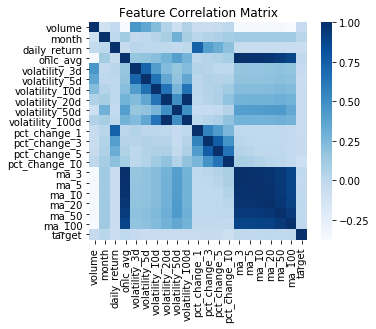

<Figure size 432x288 with 0 Axes>

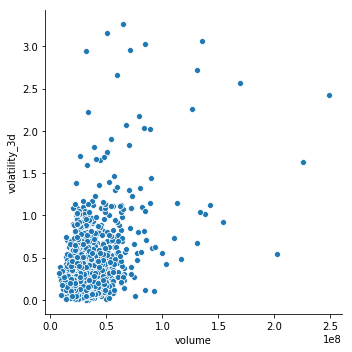

<Figure size 432x288 with 0 Axes>

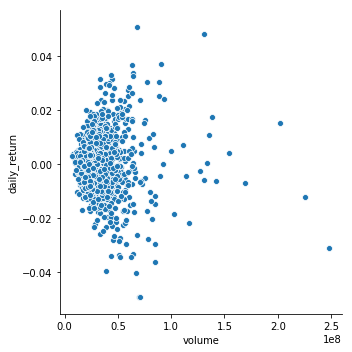

<Figure size 432x288 with 0 Axes>

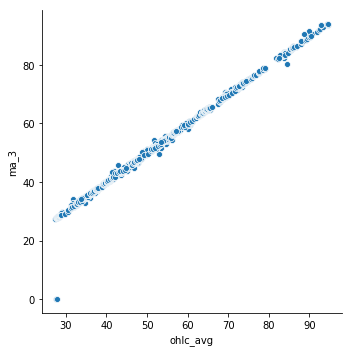

In [98]:
def plot_corr_sns(df):
    df = df.drop(columns=["open", "high", "low", "close"])
    corr = df.corr()
    
    plt.figure()
    f, ax = plt.subplots(figsize=(5, 4)) #PARAM: figsize=(15, 12)
    ax.set_title("Feature Correlation Matrix")
    sns.heatmap(corr, cmap=plt.cm.Blues, mask=np.zeros_like(corr, dtype=np.bool), square=True, ax=ax)
    # plt.savefig("./plots/DataPreparation_MSFT-Stock-Data_correlation-matrix_v4.jpeg")
    
    plt.figure()
    sns.relplot(x="volume", y="volatility_3d", data=df);
    
    plt.figure()
    sns.relplot(x="volume", y="daily_return", data=df);
    
    plt.figure()
    sns.relplot(x="ohlc_avg", y="ma_3", data=df);


plot_corr_sns(df_MSFT)
# Add other df's

In [ ]:
tbc

## Idee: Hier alle obigen Funktionen aufrufen um bequem ohne Scrollen verschiedene Sachen auszuprobieren

In [33]:
# load data
# extract features
# ...